## 빅데이터 활용 AI 설계
# Seq2seq Eng-Kor Translater
- Neural Machine Translation using word level seq2seq model<br>(https://medium.com/@dev.elect.iitd/neural-machine-translation-using-word-level-seq2seq-model-47538cba8cd7)
- 원본 소스 : https://github.com/devm2024/nmt_keras

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import string
from string import digits
import re

### 영어-한국어 번역 파일 불러오기

In [5]:
df= pd.read_csv('kor.txt', delimiter='\t', names=['eng', 'kor'])

In [6]:
df.head()

,eng,kor
0,Who?,누구?
1,Hello!,안녕!
2,No way!,절대 아니야.
3,No way!,그럴리가!
4,Goodbye!,안녕!


In [7]:
df.tail()

,eng,kor
904,"Tom was standing outside the window, listening...",톰은 메리와 존이 말하는 것을 들으며 창문 밖에 서 있었다.
905,Tom occasionally prods me to work out with him...,톰은 때때로 같이 운동하자고 졸라댔지만 나는 정말 운동에 관심이 없다.
906,I think I can speak French well enough to say ...,나는 내가 말하고 싶은 것은 거의 다 말할 수 있을 정도로 불어를 잘 한다고 생각한다.
907,It's not always possible to eat well when you'...,"당신이 세계를 여행하는 동안, 항상 잘먹는 것이 가능하지는 않습니다."
908,Make a good translation of the sentence that y...,당신이 번역할 문장에 충실하게 번역하십시오. 다른 언어로 번역된 문장의 영향을 받지...


In [8]:
df.shape

(909, 2)

### 900개 문장만 사용

In [14]:
lines = df[:900].copy()
lines.shape

(900, 2)

In [15]:
lines.tail()

,eng,kor
895,Tom gave Mary some advice on how to pass multi...,탐은 메리에게 선다형 시험에 통과하는 방법에 대해 조언했다.
896,Tom talks to his mother more often than he tal...,톰은 아버지보다 어머니와 대화를 더 자주 한다.
897,That would be like sawing off the branch that ...,그건 니가 앉아있는 가지를 쳐내는 꼴이야.
898,How can anyone trust anything Tom says? He's a...,어떻게 누군가가 톰이 말하는 것을 믿을 수 있지? 그는 병적인 거짓말쟁이야.
899,"After driving for eight hours, Tom just couldn...",8시간 동안 운전을 한 후에 톰은 더이상 운전을 할 수 없었다.


### 데이터 정리

In [16]:
lines.eng=lines.eng.apply(lambda x: x.lower())
lines.kor=lines.kor.apply(lambda x: x.lower())

lines.eng=lines.eng.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))
lines.kor=lines.kor.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))

exclude = set(string.punctuation) # '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.kor=lines.kor.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# 숫자를 지운다
remove_digits = str.maketrans('', '', digits)
lines.eng=lines.eng.apply(lambda x: x.translate(remove_digits))
lines.kor=lines.kor.apply(lambda x: x.translate(remove_digits))

### 한국어 문장에 태그 달기
- START_ 와 _END

In [18]:
lines.kor = lines.kor.apply(lambda x : 'START_ '+ x + ' _END')

In [19]:
lines.head()

,eng,kor
0,who,START_ 누구 _END
1,hello,START_ 안녕 _END
2,no way,START_ 절대 아니야 _END
3,no way,START_ 그럴리가 _END
4,goodbye,START_ 안녕 _END


### 단어 목록 만들기

In [20]:
eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        eng_words.add(word)
    
kor_words=set()
for kor in lines.kor:
    for word in kor.split():
        kor_words.add(word)

In [21]:
eng_words = sorted(list(eng_words))
kor_words = sorted(list(kor_words))

len(eng_words), len(kor_words)

(1138, 1990)

In [22]:
display(eng_words[:10], kor_words[:10])

['COMMA',
 'a',
 'about',
 'above',
 'abroad',
 'absolutely',
 'accept',
 'accurate',
 'actions',
 'active']

['COMMA',
 'START_',
 '_END',
 'a와',
 'birthday',
 'b의',
 'happy',
 'mary가',
 'tom과',
 'tom은']

### 단어 사전 만들기

In [23]:
eng_w2i = { word: i for i, word in enumerate(eng_words) }
kor_w2i = { word: i for i, word in enumerate(kor_words) }

eng_i2w = { i: word for word, i in eng_w2i.items() }
kor_i2w = { i: word for word, i in kor_w2i.items() }

In [24]:
len(eng_i2w), len(kor_i2w)

(1138, 1990)

### 최대 문장 길이

In [25]:
eng_sen_max = max([len(sen.split()) for sen in lines.eng])
kor_sen_max = max([len(sen.split()) for sen in lines.kor])

eng_sen_max, kor_sen_max

(13, 15)

### 입력/출력 데이터 생성 (어레이)

In [26]:
encoder_input_data = np.zeros([len(lines), eng_sen_max])
decoder_input_data = np.zeros([len(lines), kor_sen_max])
decoder_output_data = np.zeros([len(lines), kor_sen_max, len(kor_words)])

In [27]:
for line, (eng,kor) in enumerate(zip(lines.eng, lines.kor)):
    for t, word in enumerate(eng.split()):
        encoder_input_data[line,t] = eng_w2i[word]
        
    for t, word in enumerate(kor.split()):
        decoder_input_data[line,t] = kor_w2i[word]
        if t>0:
            decoder_output_data[line,t-1,kor_w2i[word]] = 1 # START_ 가 빠지고 하나씩 당겨짐

### 인코더  생성

In [28]:
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense

C:\Anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [48]:
embedding_size = 50

enc_inputs = Input((eng_sen_max,))
enc_embed = Embedding(len(eng_words),embedding_size)(enc_inputs)

enc_lstm = LSTM(50, return_state=True)
enc_output, state_h, state_c = enc_lstm(enc_embed)

enc_states = [state_h, state_c]

### 디코더 생성

In [49]:
dec_inputs = Input((kor_sen_max,))
dec_embed = Embedding(len(kor_words), embedding_size)(dec_inputs)

dec_lstm = LSTM(50, return_sequences=True)
dec_outputs = dec_lstm(dec_embed, initial_state=enc_states)

dec_outputs = Dense(len(kor_words), activation='softmax')(dec_outputs)

In [50]:
model = Model([enc_inputs, dec_inputs], dec_outputs)

In [2]:
from keras.layers import LSTM
help(LSTM)

C:\Anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Help on class LSTM in module keras.layers.recurrent:

class LSTM(RNN)
 |  Long Short-Term Memory layer - Hochreiter 1997.
 |  
 |  # Arguments
 |      units: Positive integer, dimensionality of the output space.
 |      activation: Activation function to use
 |          (see [activations](../activations.md)).
 |          Default: hyperbolic tangent (`tanh`).
 |          If you pass `None`, no activation is applied
 |          (ie. "linear" activation: `a(x) = x`).
 |      recurrent_activation: Activation function to use
 |          for the recurrent step
 |          (see [activations](../activations.md)).
 |          Default: hard sigmoid (`hard_sigmoid`).
 |          If you pass `None`, no activation is applied
 |          (ie. "linear" activation: `a(x) = x`).
 |      use_bias: Boolean, whether the layer uses a bias vector.
 |      kernel_initializer: Initializer for the `kernel` weights matrix,
 |          used for the linear transformation of the inputs.
 |          (see [initializ

In [51]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [52]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 13)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 13, 50)       56900       input_5[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 15, 50)       99500       input_6[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LS

### 학습 시키기

In [61]:
h = model.fit([encoder_input_data, decoder_input_data], decoder_output_data,
              batch_size=16, epochs=30, validation_split=0.1)

Train on 810 samples, validate on 90 samples
Epoch 1/30
810/810 [==============================] - 10s 13ms/step - loss: 1.6410 - acc: 0.0738 - val_loss: 4.5402 - val_acc: 0.0748
Epoch 2/30
810/810 [==============================] - 10s 13ms/step - loss: 1.6181 - acc: 0.0743 - val_loss: 4.4469 - val_acc: 0.0770
Epoch 3/30
810/810 [==============================] - 10s 12ms/step - loss: 1.5980 - acc: 0.0753 - val_loss: 4.6773 - val_acc: 0.0778
Epoch 4/30
810/810 [==============================] - 10s 13ms/step - loss: 1.5787 - acc: 0.0766 - val_loss: 4.6074 - val_acc: 0.0785
Epoch 5/30
810/810 [==============================] - 10s 13ms/step - loss: 1.5600 - acc: 0.0770 - val_loss: 4.5289 - val_acc: 0.0778
Epoch 6/30
810/810 [==============================] - 11s 13ms/step - loss: 1.5432 - acc: 0.0776 - val_loss: 4.4371 - val_acc: 0.0793
Epoch 7/30
810/810 [==============================] - 10s 13ms/step - loss: 1.5295 - acc: 0.0791 - val_loss: 4.5574 - val_acc: 0.0785
Epoch 8/30
810/81

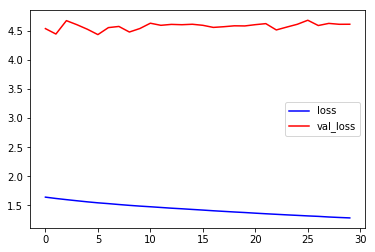

In [62]:
plt.plot(h.history['loss'], 'b-')
plt.plot(h.history['val_loss'], 'r-')
#plt.ylim(0,3)
plt.legend(['loss', 'val_loss'])

### 번역하기

In [64]:
s = 'I love you'
l = s.lower().split()
l = [word for word in l if word in eng_words][:eng_sen_max]

### 영어 입력
eng_text = np.zeros([1,eng_sen_max])
for t,word in enumerate(l):
    eng_text[0,t] = eng_w2i[word]

### 한국어 입력
kor_text = np.zeros([1,kor_sen_max])
kor_text[0,0] = kor_w2i['START_']
result = []

for i in range(kor_sen_max):
    pred_y = model.predict([eng_text,kor_text])[0,i]
    
    idx = np.argmax(pred_y)
    word = kor_i2w[idx]
    result.append(word)
    
    if word=='_END' or i==(kor_sen_max-1): break
        
    kor_text[0,i+1] = idx
    
display(s,l,' '.join(result))

'I love you'

['i', 'love', 'you']

'그 약은 두렵지 것이다 _END'